In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
import matplotlib as mpl
mpl.style.use('seaborn')
import ast
import os

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/.shortcut-targets-by-id/1ca8px2VUzY6uBCgo13kYoW0_JuynXfG7/1.0.1/'

In [ ]:
def get_label_info(path):
  def add_path(str2):
      return path + str2
  def aggregate_diagnostic(y_dic):
      tmp = []
      for key in y_dic.keys():
          if key in agg_df.index:
              tmp.append(agg_df.loc[key].diagnostic_class)
      if len(tmp) == 0:
        return "NL"
      return list(set(tmp))[0]
  Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
  Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

      # Load scp_statements.csv for diagnostic aggregation
  agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
  agg_df = agg_df[agg_df.diagnostic == 1]

      # Apply diagnostic superclass
      #target label of the classification
  Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
  Y['new_filename'] = Y.filename_hr.map(add_path)
  return Y[["new_filename","diagnostic_superclass","age","sex"]]

In [ ]:
y = get_label_info(path)
y

,new_filename,diagnostic_superclass,age,sex
ecg_id,,,,
1,/content/gdrive/.shortcut-targets-by-id/1ca8px...,NORM,56.0,1
2,/content/gdrive/.shortcut-targets-by-id/1ca8px...,NORM,19.0,0
3,/content/gdrive/.shortcut-targets-by-id/1ca8px...,NORM,37.0,1
4,/content/gdrive/.shortcut-targets-by-id/1ca8px...,NORM,24.0,0
5,/content/gdrive/.shortcut-targets-by-id/1ca8px...,NORM,19.0,1
...,...,...,...,...
21833,/content/gdrive/.shortcut-targets-by-id/1ca8px...,STTC,67.0,1
21834,/content/gdrive/.shortcut-targets-by-id/1ca8px...,NORM,93.0,0
21835,/content/gdrive/.shortcut-targets-by-id/1ca8px...,STTC,59.0,1


In [ ]:
y = y.dropna(how='any',axis=0) 
y.diagnostic_superclass.value_counts()

NORM    9484
MI      3820
STTC    3712
HYP     2634
CD      1695
NL       403
Name: diagnostic_superclass, dtype: int64

# plot functions

## show_labels_hist funtion

In [ ]:
def show_labels_hist(labels, dataset_name):
  plt.hist(y.diagnostic_superclass)
  plt.title("Distribution of labels in "+dataset_name)

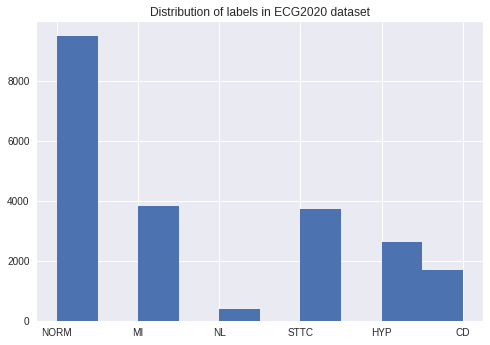

In [ ]:
# test
train_labels = y.diagnostic_superclass
show_labels_hist(train_labels, 'ECG2020 dataset')

##  show_data function

In [ ]:
def show(data, label,length):
  for i, sig_data in enumerate(data):
    plt.figure()
    plt.title(label+'(signal:'+str(i)+')')
    plt.plot(sig_data[0:length])
    plt.show()

In [ ]:
!pip install wfdb

     |████████████████████████████████| 122kB 18.2MB/s 


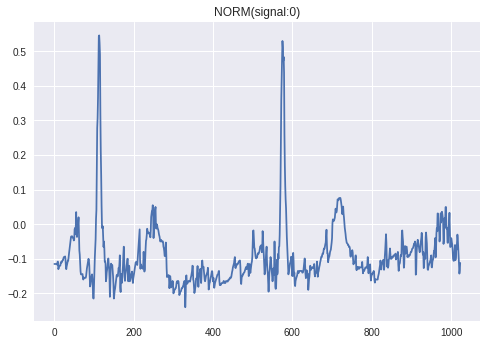

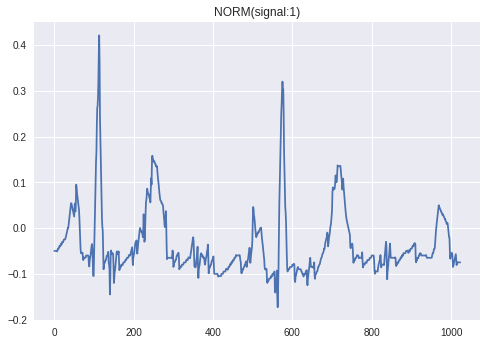

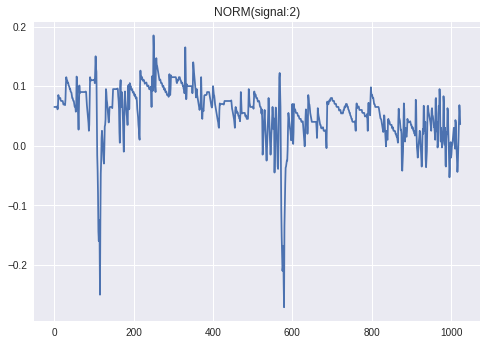

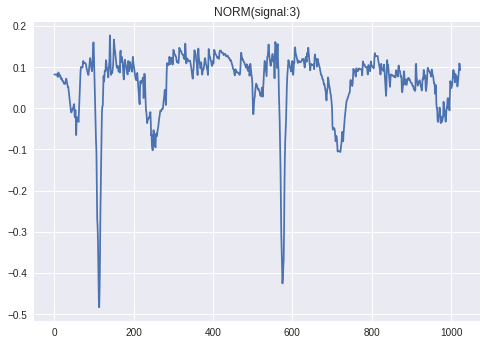

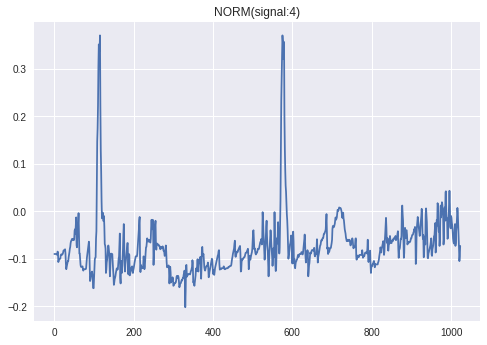

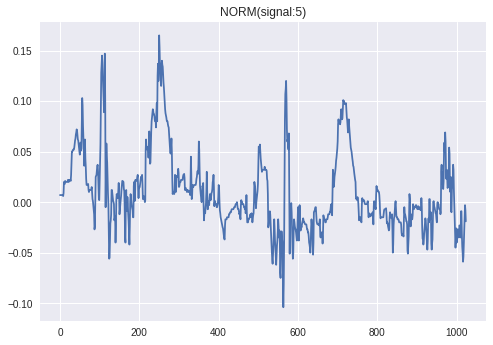

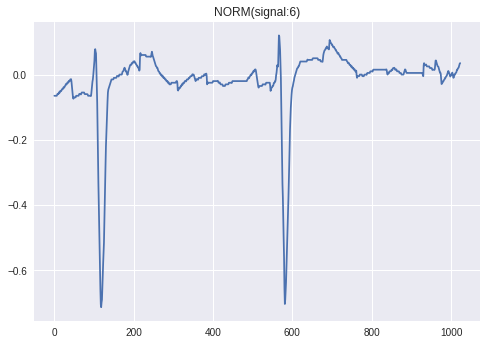

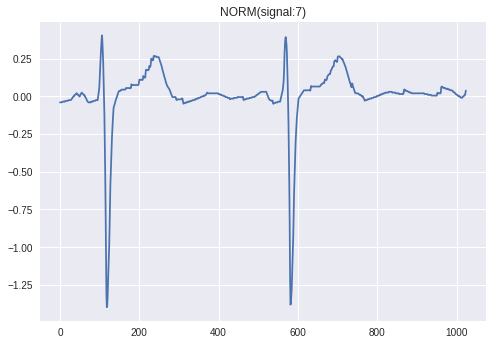

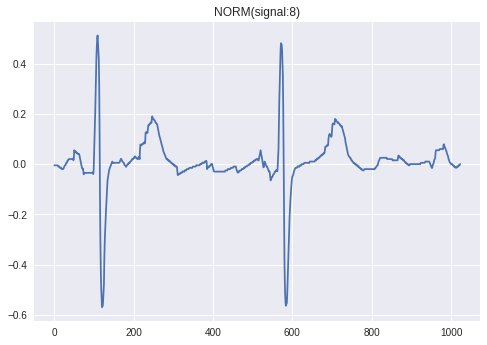

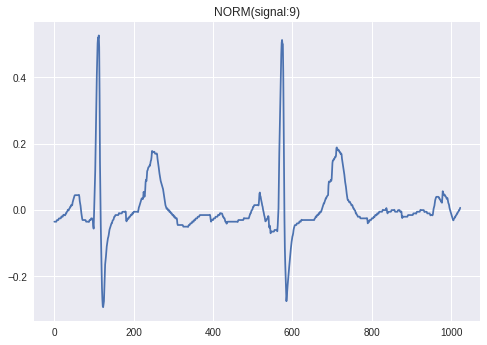

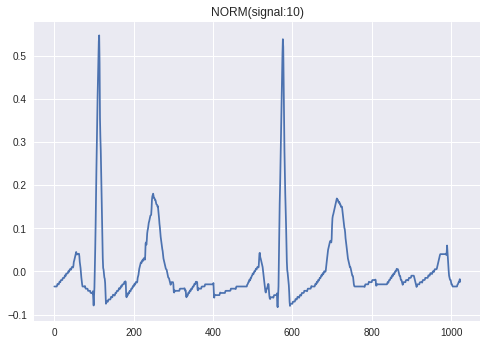

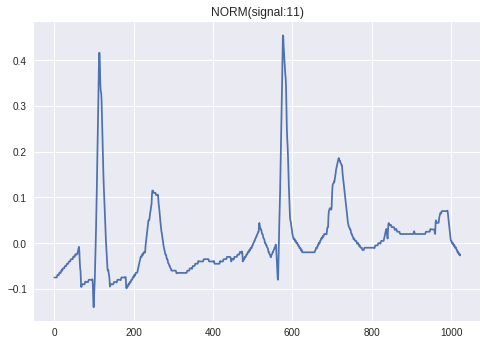

In [ ]:
#test 
import wfdb
file_path = y.new_filename.iloc[0]
label = y.diagnostic_superclass.iloc[0]
data = wfdb.rdrecord(file_path).p_signal.T.astype("float16")
show(data, label,1024) 

# show_tf_dataset function

In [ ]:
def show_tf_dataset(dataset) 
  iterator = iter(dataset)
  raw_example = next(iterator)
  parsed_data = raw_example[0].numpy()
  label = raw_example[1].numpy()
  print('batch_data:',parsed_data, 'shape:', parsed_data.shape, '\n batcah_labels:',label, 'shape:', label.shape)

#test
#
#show_dataset(ds_test0)

## plot_train_history function

In [ ]:
def plot_train_history(history, field, fn):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index+1, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  best_index = fn(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [ ]:
history = path + '/history/'

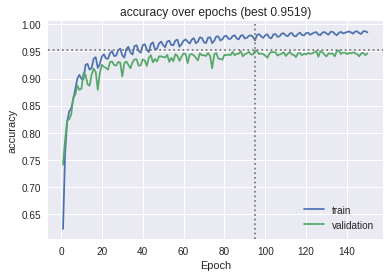

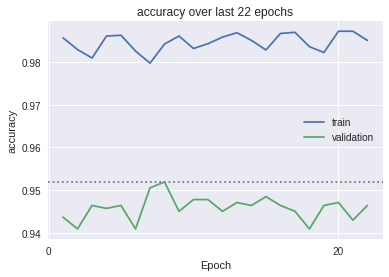

In [ ]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

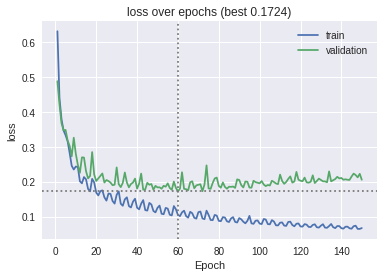

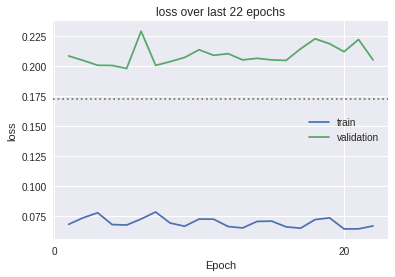

In [ ]:
plot_train_history(history, 'loss', lambda x: np.argmin(x))

## plot_confusion_matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 350   35]
 [  36 1035]]


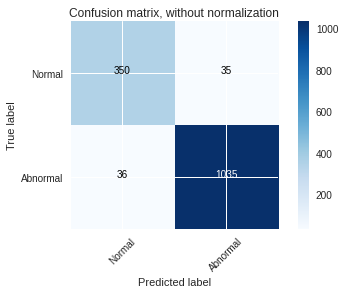

In [ ]:
y_pred = (base_model.predict(X_ptbdb_test) > 0.5).astype("int32")

#  confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

#  non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')